In [5]:
import time
import hydroeval as he
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import sys
from datetime import date
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
import math
from scipy import stats
import statistics
import folium
import os
import hydroeval as he

## **STATISTICS**

### **Calculate Mean, SD, and Max**

In [2]:
# Read the input CSV file
input_file = 'DataFolder/annual_max_matched.csv'
df = pd.read_csv(input_file)

# Group the data by 'ID_num'
grouped = df.groupby('ID_num')

# Initialize lists to store the results
results = []

# Define the columns to calculate mean and standard deviation for
columns_to_process = [
    'obs30m', 'obs1h', 'obs2h', 'obs3h', 'obs6h', 'obs12h', 'obs24h', 'obs48h', 'obs72h',
    'pre30m', 'pre1h', 'pre2h', 'pre3h', 'pre6h', 'pre12h', 'pre24h', 'pre48h', 'pre72h'
]

# Iterate through unique 'ID_num' values and calculate mean and std
for group_name, group_df in grouped:
    result = {}

    # Copy 'ID_num', 'Lat', and 'Lon' to the result
    result['ID_num'] = group_name
    result['Lat'] = group_df['Lat'].iloc[0]
    result['Lon'] = group_df['Lon'].iloc[0]

    for col in columns_to_process:
        result[f'{col}_mn'] = group_df[col].mean()
        result[f'{col}_sd'] = group_df[col].std()
        result[f'{col}_mx'] = group_df[col].max()

    results.append(result)

# Create a new DataFrame from the results
result_df = pd.DataFrame(results)

# Save results
output_file = 'Result_folder/station_matched_mn_sd.csv'
result_df.to_csv(output_file, index=False)
print("Done Processing")

Done Processing


### **Percent Diff Stats**

In [3]:
# Read the input CSV file
input_file = 'DataFolder/annual_max_matched.csv'
output_file = 'Result_folder/station_matched_pd.csv'

df = pd.read_csv(input_file)

# Define the function to calculate the percent difference
def calculate_percent_diff(row, duration):
    obs_column = f'obs{duration}'
    pre_column = f'pre{duration}'
    
    if row[obs_column] == 0:
        return None  # Skip rows with zero values
    percent_diff = 100 * (row[pre_column] - row[obs_column]) / row[obs_column]
    return percent_diff

# Calculate the percent difference and add new columns
durations = ['30m', '1h', '2h', '3h', '6h', '12h', '24h', '48h', '72h']

for duration in durations:
    df[f'PercentDiff_{duration}'] = df.apply(calculate_percent_diff, args=(duration,), axis=1)

# Calculate the mean and standard deviation for each unique 'ID_num'
mean_std_df = df.groupby('ID_num').agg({'ID_num': 'first', 'Lat': 'first', 'Lon': 'first'})
for duration in durations:
    mean_std_df[f'mean{duration}'] = df.groupby('ID_num')[f'PercentDiff_{duration}'].mean()
    mean_std_df[f'std{duration}'] = df.groupby('ID_num')[f'PercentDiff_{duration}'].std()


# # Drop rows after the 2353rd row
# mean_std_df = mean_std_df.iloc[:2352]

# Save the result to a new CSV file
mean_std_df.to_csv(output_file, index=False)

print("Completed Processing")

Completed Processing


### **Plot Boxplot**

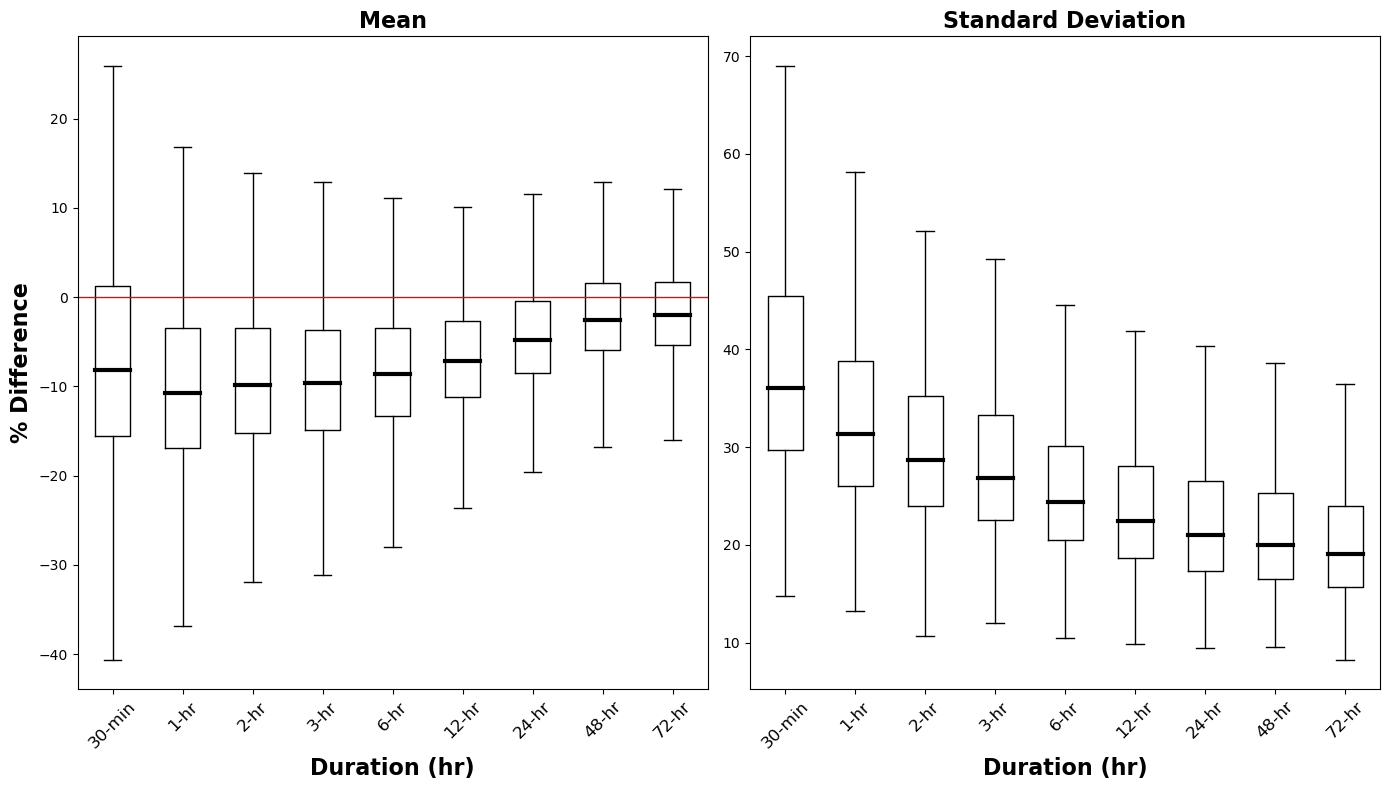

In [4]:
# Read the input CSV file
df1 = pd.read_csv('./Result_folder/station_matched_pd.csv') 

xar2 = df1.to_xarray()

SpctMn1 = xar2['mean30m']; SpctMn2 = xar2['mean1h']; SpctMn3 = xar2['mean2h']; SpctMn4 = xar2['mean3h']; SpctMn5 = xar2['mean6h']; 
SpctMn6 = xar2['mean12h']; SpctMn7 = xar2['mean24h']; SpctMn8 = xar2['mean48h']; SpctMn9 = xar2['mean72h'];

SpctSD1 = xar2['std30m']; SpctSD2 = xar2['std1h']; SpctSD3 = xar2['std2h']; SpctSD4 = xar2['std3h']; SpctSD5 = xar2['std6h']; 
SpctSD6 = xar2['std12h']; SpctSD7 = xar2['std24h']; SpctSD8 = xar2['std48h']; SpctSD9 = xar2['std72h'];

SpctMn = [SpctMn1, SpctMn2, SpctMn3, SpctMn4, SpctMn5, SpctMn6, SpctMn7, SpctMn8, SpctMn9]
SpctSD = [SpctSD1, SpctSD2, SpctSD3, SpctSD4, SpctSD5, SpctSD6, SpctSD7, SpctSD8, SpctSD9]
tit = ['30-min', '1-hr', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr', '48-hr', '72-hr']

fig, (ax2, ax1) = plt.subplots(ncols=2, nrows=1, figsize =(14, 8), sharey=False) # , ax3, ax4
font1 = {'family':'serif','color':'black','size':15, 'weight':'light'}   # darkblue
font2 = {'family':'serif','color':'black','size':10, 'weight':'bold'}     # darkred

# STANDARD DEVIATION OF MAXIMUMS (IMERG)
# Creating plot
data1 = SpctSD  # DifSD  # imgQ3
# bp3 = ax1.boxplot(data3)
ax1.boxplot(data1, showfliers=False, medianprops = dict(color = "black", linewidth = 3))
ax1.set_xticklabels(tit, fontsize=12, rotation=45)
ax1.set_title("Standard Deviation",  fontweight='bold', fontsize=16)
ax1.set_xlabel('Duration (hr)', fontweight='bold', fontsize=16)
# ax1.yaxis.grid(True, color ="black")
# ax1.axhline(y=5, color='red', linestyle='-', linewidth=1)  # Solid line at y=0
# ax1.set_ylim(bottom=-1, top=15)
# ax1.set_ylabel('Estimates (mm)', fontdict = font2)


# MEAN OF MAXIMUMS (IMERG)
# Creating plot
data2 = SpctMn   # DifMean  # imgQ1
bp2 = ax2.boxplot(data2, showfliers=False, medianprops = dict(color = "black", linewidth = 3))
ax2.set_xticklabels(tit, fontsize=12, rotation=45)
ax2.set_title("Mean", fontweight='bold', fontsize=16)
ax2.set_xlabel('Duration (hr)', fontweight='bold', fontsize=16)
ax2.set_ylabel('% Difference', fontweight='bold', fontsize=16)  # ax2.set_ylabel('Precipitation maximums (mm)', fontdict = font2)
# ax2.yaxis.grid(True, color ="black")
ax2.axhline(y=0, color='red', linestyle='-', linewidth=1)  # Solid line at y=0
# ax2.set_ylim(bottom=-15, top=15)

plt.tight_layout()
plt.savefig("Plots/PDplot.png")
plt.show()

### **Statistics - Mean**

In [11]:
# Read input data
dfmn = pd.read_csv('./Result_folder/station_matched_mn_sd.csv')
xarmn = dfmn.to_xarray()

# Define observed and predicted variables
obs_list = [xarmn['obs30m_mn'], xarmn['obs1h_mn'], xarmn['obs2h_mn'], xarmn['obs3h_mn'], xarmn['obs6h_mn'],
            xarmn['obs12h_mn'], xarmn['obs24h_mn'], xarmn['obs48h_mn'], xarmn['obs72h_mn']]
pre_list = [xarmn['pre30m_mn'], xarmn['pre1h_mn'], xarmn['pre2h_mn'], xarmn['pre3h_mn'], xarmn['pre6h_mn'],
            xarmn['pre12h_mn'], xarmn['pre24h_mn'], xarmn['pre48h_mn'], xarmn['pre72h_mn']]
titles = ['30-min', '1-hr', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr', '48-hr', '72-hr']
durations = [0.5, 1, 2, 3, 6, 12, 24, 48, 72]

# Create output directory if it doesn't exist
output_dir = "Stat_folder"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

results = []

# Extended Evaluation Function
def STATS(obs, pred):
    # Remove NaNs to avoid invalid calculations
    mask = np.isfinite(obs) & np.isfinite(pred)
    obs = obs[mask]
    pred = pred[mask]

    # Correlation coefficient
    r_cor, _ = stats.pearsonr(obs, pred)
    r_cor_val = np.round(r_cor, 3)

    # Relative Bias (RB%)
    RB1 = np.sum(pred - obs) / np.sum(obs) * 100
    RB = np.round(RB1, 3)

    # RMSE
    rmse = np.sqrt(np.mean((pred - obs) ** 2))
    rmse_val = np.round(rmse, 5)

    # Mean Bias Ratio (MBR)
    mbr = np.mean(pred) / np.mean(obs)
    mbr = np.clip(mbr, 0, 1)
    mbr_val = np.round(mbr, 4)

    # Nash–Sutcliffe Efficiency (NSE)
    nse = he.evaluator(he.nse, pred, obs)[0]
    nse_val = np.round(nse, 4)

    # Kling–Gupta Efficiency (KGE)
    kge, _, _, _ = he.evaluator(he.kge, pred, obs)
    kge_val = np.round(kge[0], 4)

    # print("------------Start--------------")
    # print(f"r Cor  : {r_cor_val}")
    # print(f"R Bias : {RB}")
    # print(f"RMSE   : {rmse_val}")
    # print(f"MBR    : {mbr_val}")
    # print(f"NSE    : {nse_val}")
    # print(f"KGE    : {kge_val}")
    # print("----------- END---------------\n")

    return r_cor_val, RB, rmse_val, mbr_val, nse_val, kge_val


# Loop through datasets and collect results
for obs, pred, label, duration in zip(obs_list, pre_list, titles, durations):
    # print(f"{label}:")
    r, rb, rmse, mbr, nse, kge = STATS(obs.values, pred.values)
    nrmse = np.round(rmse / duration, 5)
    results.append([label, duration, r, rb, rmse, nrmse, mbr, nse, kge])

# Save results to CSV
df_out = pd.DataFrame(results, columns=['Label', 'Duration (hr)', 'r', 'RB%', 'RMSE (mm)', 'NRMSE', 'MBR', 'NSE', 'KGE'])
output_path = os.path.join(output_dir, 'stat_mean_diff.csv')
df_out.to_csv(output_path, index=False)

print(f"Calculation completed and saved to {output_path}")


Calculation completed and saved to Stat_folder\stat_mean_diff.csv


### **Statistics - Standard Deviation**

In [12]:
# Load the standard deviation dataset
dfsd = pd.read_csv('./Result_folder/station_matched_mn_sd.csv')
xarsd = dfsd.to_xarray()

# Define observed and predicted fields (standard deviation data)
obs_list = [xarsd['obs30m_sd'], xarsd['obs1h_sd'], xarsd['obs2h_sd'], xarsd['obs3h_sd'], xarsd['obs6h_sd'],
            xarsd['obs12h_sd'], xarsd['obs24h_sd'], xarsd['obs48h_sd'], xarsd['obs72h_sd']]
pre_list = [xarsd['pre30m_sd'], xarsd['pre1h_sd'], xarsd['pre2h_sd'], xarsd['pre3h_sd'], xarsd['pre6h_sd'],
            xarsd['pre12h_sd'], xarsd['pre24h_sd'], xarsd['pre48h_sd'], xarsd['pre72h_sd']]
titles = ['30-min', '1-hr', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr', '48-hr', '72-hr']
durations = [0.5, 1, 2, 3, 6, 12, 24, 48, 72]

# Create output directory if it doesn't exist
output_dir = "Stat_folder"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

results = []

# Extended Evaluation Function
def STATS(obs, pred):
    # Remove NaNs to avoid invalid calculations
    mask = np.isfinite(obs) & np.isfinite(pred)
    obs = obs[mask]
    pred = pred[mask]

    # Correlation coefficient
    r_cor, _ = stats.pearsonr(obs, pred)
    r_cor_val = np.round(r_cor, 3)

    # Relative Bias (RB%)
    RB1 = np.sum(pred - obs) / np.sum(obs) * 100
    RB = np.round(RB1, 3)

    # RMSE
    rmse = np.sqrt(np.mean((pred - obs) ** 2))
    rmse_val = np.round(rmse, 5)

    # Mean Bias Ratio (MBR)
    mbr = np.mean(pred) / np.mean(obs)
    mbr = np.clip(mbr, 0, 1)
    mbr_val = np.round(mbr, 4)

    # Nash–Sutcliffe Efficiency (NSE)
    nse = he.evaluator(he.nse, pred, obs)[0]
    nse_val = np.round(nse, 4)

    # Kling–Gupta Efficiency (KGE)
    kge, _, _, _ = he.evaluator(he.kge, pred, obs)
    kge_val = np.round(kge[0], 4)

    # print("------------Start--------------")
    # print(f"r Cor  : {r_cor_val}")
    # print(f"R Bias : {RB}")
    # print(f"RMSE   : {rmse_val}")
    # print(f"MBR    : {mbr_val}")
    # print(f"NSE    : {nse_val}")
    # print(f"KGE    : {kge_val}")
    # print("----------- END---------------\n")

    return r_cor_val, RB, rmse_val, mbr_val, nse_val, kge_val


# Loop through datasets and collect results
for obs, pred, label, duration in zip(obs_list, pre_list, titles, durations):
    # print(f"{label}:")
    r, rb, rmse, mbr, nse, kge = STATS(obs.values, pred.values)
    nrmse = np.round(rmse / duration, 5)
    results.append([label, duration, r, rb, rmse, nrmse, mbr, nse, kge])

# Save results to CSV
df_out = pd.DataFrame(results, columns=['Label', 'Duration (hr)', 'r', 'RB%', 'RMSE (mm)', 'NRMSE', 'MBR', 'NSE', 'KGE'])
output_path = os.path.join(output_dir, 'stat_sd_diff.csv')
df_out.to_csv(output_path, index=False)

print(f"Calculation completed and saved to {output_path}")


Calculation completed and saved to Stat_folder\stat_sd_diff.csv


In [ ]:
# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAll.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Create a directory to save results
output_dir = "ResultsData"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Step 3: Define the function to calculate the statistical metrics
def calculate_stats(obs, pred):
    # Correlation Coefficient (CC)
    cc, _ = stats.pearsonr(obs, pred)
    
    # Percentage Relative Bias (PRB)
    prb = np.sum(pred - obs) / np.sum(obs) * 100
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((pred - obs) ** 2))
    
    # Mean Bias Ratio (MBR) with flooring at 0 and capping at 1
    mbr = np.mean(pred) / np.mean(obs)
    mbr = np.clip(mbr, 0, 1)  # Ensures MBR is between 0 and 1
    
    # Nash-Sutcliffe Efficiency (NSE)
    nse = he.evaluator(he.nse, pred, obs)[0]
    
    # Kling-Gupta Efficiency (KGE)
    kge, r_cor, alpha, beta = he.evaluator(he.kge, pred, obs)
    
    return cc, prb, rmse, mbr, nse, kge[0]

# Step 4: Initialize the results list
results = []

# Step 5: Calculate statistics for each year
for year in years:
    year_data = filtered_data[filtered_data['Year'] == year]
    obs = year_data['obs24h_RAI'].values
    pred = year_data['pre24h_MRAI'].values
    
    if len(obs) > 0 and len(pred) > 0:
        # Calculate statistical metrics
        cc, prb, rmse, mbr, nse, kge = calculate_stats(obs, pred)
        # Append the result for each year
        results.append([year, cc, prb, rmse, mbr, nse, kge])

# Step 6: Convert results to a DataFrame and save it as a CSV file
results_df = pd.DataFrame(results, columns=['Year', 'CC', 'PRB', 'RMSE', 'MBR', 'NSE', 'KGE'])
output_file_path = os.path.join(output_dir, 'statByYearData.csv')
results_df.to_csv(output_file_path, index=False)

print("Statistical results saved to:", output_file_path)
